# Natural Language Processing Project

>Goals:
- Build a dataset of 100 Github repositories' readme text
- Explore the text of the readme's and find connections to programming language
- Build a classification ML model that predicts the programming language used in a repo based on readme content. 

In [68]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# acquire
from requests import get
from bs4 import BeautifulSoup
from time import sleep
import os

# prepare
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# explore
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# model
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

---
## Acquire

In [2]:
def make_soup(url):
    '''
    This helper function takes in a url and requests and parses HTML
    returning a soup object.
    '''
    headers = {'User-Agent': 'Sir Galahad'} 
    response = get(url, headers=headers)    
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [3]:
def get_language_urls():
    '''
    This function scrapes all of the Codeup blog urls from
    the main Codeup blog page and returns a list of urls.
    '''
    
    urls = []
    
    languages = ['JavaScript', 'Python', 'Java', 'HTML']
    
    for language in languages:
        for i in range(1,11):
            # first page for most starred repos on GH
            url = f'https://github.com/search?l={language}&p={i}&q=stars%3A%3E0&s=stars&type=Repositories'

            urls.append(url)
    return urls

In [4]:
urls = get_language_urls()

In [5]:
urls

['https://github.com/search?l=JavaScript&p=1&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=2&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=3&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=4&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=5&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=6&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=7&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=8&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=9&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=JavaScript&p=10&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=Python&p=1&q=stars%3A%3E0&s=stars&type=Repositories',
 'https://github.com/search?l=Pytho

In [6]:
def get_all_urls(urls):
    '''
    This function scrapes all of the Codeup blog urls from
    the main Codeup blog page and returns a list of urls.
    '''
    
    repo_urls = []
    
    for url in urls:
        # Make request and soup object using helper
        soup = make_soup(url)
        sleep(1)
        # Create a list of the anchor elements that hold the urls.
        urls_list = soup.find_all('a', class_='v-align-middle')
    
        # I'm using a set comprehension to return only unique urls.
        urls_set = {'https://github.com' + link.get('href') for link in urls_list}
        urls_set = list(urls_set)
        repo_urls.extend(urls_set)

    # I'm converting my set to a list of urls.
    # urls = list(urls) 
        
    return repo_urls

In [7]:
def get_all_urls(urls):
    '''
    This function scrapes all of the urls from
    the list of github search result urls and returns a list of urls.
    '''
    
    repo_urls = []
    n = 0
    for url in urls:
        # Make request and soup object using helper
        soup = make_soup(url)
        sleep(3)
        n = n + 1
        print(f"Scraping loop number {n}")
        # Create a list of the anchor elements that hold the urls.
        urls_list = soup.find_all('a', class_='v-align-middle')
    
        # I'm using a set comprehension to return only unique urls.
        urls_set = {'https://github.com' + link.get('href') for link in urls_list}
        urls_set = list(urls_set)
        repo_urls.extend(urls_set)
    # I'm converting my set to a list of urls.
    # urls = list(urls) 
        
    return repo_urls

In [8]:
#all_urls = get_all_urls(urls)

In [9]:
#len(all_urls)

In [10]:
def get_blog_articles(urls, cached=False):
    '''
    This function takes in a list of Codeup Blog urls and a parameter
    with default cached == False which scrapes the title and text for each url, 
    creates a list of dictionaries with the title and text for each blog, 
    converts list to df, and returns df.
    If cached == True, the function returns a df from a json file.
    '''
    if cached == True:
        df = pd.read_json('github_repos.json')
        
    # cached == False completes a fresh scrape for df     
    else:

        # Create an empty list to hold dictionaries
        articles = []

        # Loop through each url in our list of urls
        for url in urls:

            # Make request and soup object using helper
            soup = make_soup(url)

            # Save the programming language of each repo in variable language
            language = soup.find('span', class_='text-gray-dark text-bold mr-1').text

            # Save the text in each repo to variable content
            content = soup.find('article', class_="markdown-body entry-content container-lg").text

            # Create a dictionary holding the title and content for each blog
            article = {'language': language, 'content': content}

            # Add each dictionary to the articles list of dictionaries
            articles.append(article)
            
        # convert our list of dictionaries to a df
        df = pd.DataFrame(articles)

        # Write df to a json file for faster access
        df.to_json('github_repos.json')
    
    return df

In [11]:
#df = get_blog_articles(all_urls)

In [12]:
df = pd.read_json('github_repos.json')

In [13]:
df.head()

,language,content
0,JavaScript,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and..."
1,JavaScript,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...
2,JavaScript,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...
3,JavaScript,Airbnb JavaScript Style Guide() {\nA mostly re...
4,JavaScript,Create React App \n\nCreate React apps with n...


In [14]:
df.language.value_counts()

JavaScript    70
Java          50
Python        40
Name: language, dtype: int64

---
## Acquire: Second Run Thorugh

In [15]:
# 25 search results pages for javascript and python
search_urls = get_language_urls()

In [16]:
# 5 second fetch timer
#repo_urls = get_all_urls(search_urls)

In [17]:
#repo_urls

In [18]:
# open repo_urls list
with open("repo_urls.txt", "r") as fp:
    repo_urls = json.load(fp)
type(repo_urls)

list

In [19]:
len(repo_urls)

300

In [20]:
# scrap, won't let me access any more than 149
#df = get_repo_content(repo_urls)

In [21]:
df.head()

,language,content
0,JavaScript,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and..."
1,JavaScript,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...
2,JavaScript,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...
3,JavaScript,Airbnb JavaScript Style Guide() {\nA mostly re...
4,JavaScript,Create React App \n\nCreate React apps with n...


In [22]:
# write repo_urls to a txt file in local drive

#with open("repo_urls.txt", "w") as fp:
#    json.dump(repo_urls, fp)

---
## Prepare

In [23]:
# functions
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = unicodedata.normalize('NFKC', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    return string

##############################

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()
    
    # Use tokenizer
    string = tokenizer.tokenize(string, return_str=True)
    
    return string

#############################

def stem(string):
    '''
    This function takes in a string and
    returns a string with words stemmed.
    '''
    # Create porter stemmer.
    ps = nltk.porter.PorterStemmer()
    
    # Use the stemmer to stem each word in the list of words we created by using split.
    stems = [ps.stem(word) for word in string.split()]
    
    # Join our lists of words into a string again and assign to a variable.
    string = ' '.join(stems)
    
    return string

#############################


def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string

#############################


def remove_stopwords(string, extra_words=[], exclude_words=[]):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')
    
    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)

    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))
    
    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords

###############################


def prep_repo_data(df, column, extra_words=[], exclude_words=[]):
    '''
    This function take in a df and the string name for a text column with 
    option to pass lists for extra_words and exclude_words and
    returns a df with the text article title, original text, stemmed text,
    lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
    '''
    df['clean'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(remove_stopwords, 
                                   extra_words=extra_words, 
                                   exclude_words=exclude_words)\
                            .apply(lemmatize)
    
    df['stemmed'] = df[column].apply(basic_clean).apply(stem)
    
    df['lemmatized'] = df[column].apply(basic_clean).apply(lemmatize)
    
    return df[['language', column, 'stemmed', 'lemmatized', 'clean']]

In [24]:
df = prep_repo_data(df, 'content')

In [25]:
df = df[df.language != 'Java']

In [26]:
df.head()

,language,content,stemmed,lemmatized,clean
0,JavaScript,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and...",bootstrap sleek intuit and power frontend fram...,bootstrap sleek intuitive and powerful fronten...,bootstrap sleek intuitive powerful frontend fr...
1,JavaScript,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...,support vuej vuej is an mitlicens open sourc p...,supporting vuejs vuejs is an mitlicensed open ...,supporting vuejs vuejs mitlicensed open source...
2,JavaScript,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...,freecodecamporg opensourc codebas and curricul...,freecodecamporgs opensource codebase and curri...,freecodecamporgs opensource codebase curriculu...
3,JavaScript,Airbnb JavaScript Style Guide() {\nA mostly re...,airbnb javascript style guid a mostli reason a...,airbnb javascript style guide a mostly reasona...,airbnb javascript style guide mostly reasonabl...
4,JavaScript,Create React App \n\nCreate React apps with n...,creat react app creat react app with no build ...,create react app create react apps with no bui...,create react app create react apps build confi...


### Prepare: for explore

In [27]:
# add a column that is a list of each word for each repo --> PREPARE.PY
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.clean] 

# column name will be words, and the column will contain lists of the words in each doc
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

In [28]:
# add a column that shows the length --> PREPARE.PY
df['doc_length'] = [len(wordlist) for wordlist in df.words]

#### Split the Data

In [29]:
# split the data --> PREPARE.PY
from sklearn.model_selection import train_test_split

train_validate, test = train_test_split(df[['language', 'clean', 'words', 'doc_length']], 
                                        stratify=df.language, 
                                        test_size=.2, 
                                        random_state=123)

train, validate = train_test_split(train_validate, 
                                   stratify=train_validate.language, 
                                   test_size=.25,
                                   random_state=123)

In [30]:
print(train.language.value_counts())
print(validate.language.value_counts())
print(test.language.value_counts())
train.head()

JavaScript    42
Python        24
Name: language, dtype: int64
JavaScript    14
Python         8
Name: language, dtype: int64
JavaScript    14
Python         8
Name: language, dtype: int64


,language,clean,words,doc_length
77,Python,payload thing list useful payload bypass web a...,"[payload, thing, list, useful, payload, bypass...",117
84,Python,tracking progress natural language processing ...,"[tracking, progress, natural, language, proces...",482
54,JavaScript,impressjs presentation framework based power c...,"[impressjs, presentation, framework, based, po...",511
45,JavaScript,english hacker script based true story xxx ok ...,"[english, hacker, script, based, true, story, ...",265
20,JavaScript,simple yet flexible javascript charting design...,"[simple, yet, flexible, javascript, charting, ...",50


---
## Explore

> **What's the proportion of each language in our data?**

In [31]:
labels = pd.concat([train.language.value_counts(), # get total counts of each language
                    train.language.value_counts(normalize=True)], axis=1) # getting the prop of each language
labels.columns = ['n', 'percent']
labels

,n,percent
JavaScript,42,0.636364
Python,24,0.363636


> **What are the most common words in READMEs?**

In [32]:
# create variables to hold words that appear in each type of repo as a single string
js_words = ' '.join(train[train.language=='JavaScript'].clean)
py_words = ' '.join(train[train.language=='Python'].clean)
all_words = ' '.join(train.clean)

js_words = re.sub(r'\s.\s', '', js_words)
py_words = re.sub(r'\s.\s', '', py_words)
all_words = re.sub(r'\s.\s', '', all_words)

# how frequently each word appears
js_freq = pd.Series(js_words.split()).value_counts()
py_freq = pd.Series(py_words.split()).value_counts()
all_words_freq = pd.Series(all_words.split()).value_counts()

In [33]:
# word frequency dataframe
word_counts = (pd.concat([js_freq, py_freq], axis=1, sort=True)
               .set_axis(['js', 'py'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
# all counts of the word
word_counts['all'] = word_counts['js'] + word_counts['py']
# proportion of each string that is javascript
word_counts['prop_js'] = word_counts['js']/word_counts['all']

In [34]:
print('Most Common Words')
word_counts.sort_values(by='all', ascending=False).head(20)

Most Common Words


,js,py,all,prop_js
code,922,153,1075,0.857674
source,912,76,988,0.923077
javascript,583,10,593,0.983137
function,489,57,546,0.895604
file,302,244,546,0.553114
use,296,237,533,0.555347
const,419,0,419,1.000000
return,208,185,393,0.529262
using,201,157,358,0.561453
mit,346,5,351,0.985755


> **What does the distribution of IDFs look like for the most common words?**

In [35]:
train.shape

(66, 4)

> **Does the length of the README vary by programming language?**

In [36]:
train.groupby('language').doc_length.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
JavaScript,42.0,1302.952381,2713.601980,40.0,151.75,357.5,968.5,15478.0
Python,24.0,1443.250000,2616.380345,9.0,204.75,430.0,827.5,10581.0


(0, 1750)

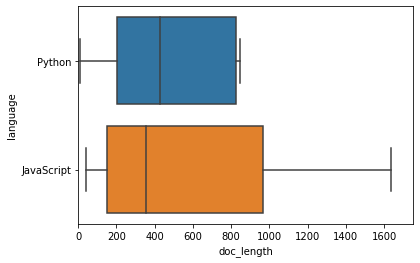

In [37]:
sns.boxplot(y=train.language, x=train.doc_length, orient="h")
plt.xlim(0, 1750)

> **Do different programming languages use a different number of unique words?**

In [38]:
print("The number of words that occur n times: ")
word_counts['all'].value_counts().head(30)

The number of words that occur n times: 


1     10955
2      2579
3      1002
4       564
5       393
6       318
7       250
8       169
9       150
10      111
11      100
12       81
13       77
14       74
15       60
16       57
17       47
18       44
19       38
25       32
23       30
21       29
20       27
26       27
29       27
24       23
22       23
27       22
31       21
37       20
Name: all, dtype: int64

In [39]:
# filtering words that occur less than 30 times
word_counts = word_counts[word_counts['all'] >= 30]
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, 10 to youre
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   js       520 non-null    int64  
 1   py       520 non-null    int64  
 2   all      520 non-null    int64  
 3   prop_js  520 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 20.3+ KB


In [40]:
# JavaScript Heavy Words
word_counts[word_counts.prop_js == 1.0].sort_values(by='js', ascending=False)

,js,py,all,prop_js
const,419,0,419,1.0
gpl30,166,0,166,1.0
agpl30,131,0,131,1.0
apache20,98,0,98,1.0
eslint,97,0,97,1.0
gpl20,90,0,90,1.0
npm,86,0,86,1.0
parcel,86,0,86,1.0
asset,70,0,70,1.0
es6,68,0,68,1.0


In [41]:
# Python Heavy Words
word_counts[(word_counts.prop_js < .40) & (word_counts.py > 45)].sort_values(by=['prop_js', 'py'])

,js,py,all,prop_js
airflow,0,47,47,0.000000
str,0,60,60,0.000000
tqdm,0,97,97,0.000000
def,0,162,162,0.000000
int,1,54,55,0.018182
sudo,2,103,105,0.019048
byte,2,61,63,0.031746
glance,3,47,50,0.060000
black,5,65,70,0.071429
yes,4,49,53,0.075472


<div class="alert alert-block alert-info">
    
**Takeaways:** 
- there are plenty of distinct words that only appear in JS and PY, those can be almost sure fire words to assign a language given the word exists in a readme.
- we can assign a bigger vector in a model to these words depending on their rank in these lists
</div>

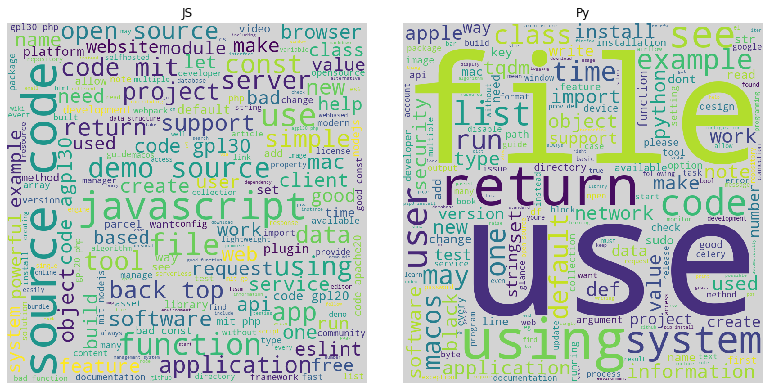

In [42]:
js_cloud = WordCloud(background_color='lightgray', 
                      height=800, width=800).generate(js_words)

py_cloud = WordCloud(background_color='lightgray', 
                      height=800, width=800).generate(py_words)

plt.figure(figsize=(10,10))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(js_cloud)
axs[1].imshow(py_cloud)

axs[0].set_title('JS')
axs[1].set_title('Py')

for ax in axs: ax.axis('off')

In [43]:
js_bigrams = pd.Series(list(nltk.ngrams(js_words.split(), 2))).value_counts()
py_bigrams = pd.Series(list(nltk.ngrams(py_words.split(), 2))).value_counts()

js_trigrams = pd.Series(list(nltk.ngrams(js_words.split(), 3))).value_counts()
py_trigrams = pd.Series(list(nltk.ngrams(py_words.split(), 3))).value_counts()

In [44]:
js_trigrams

(demo, source, code)                   211
(source, code, mit)                    168
(source, code, gpl30)                  105
(source, code, agpl30)                  95
(source, code, gpl20)                   77
                                      ... 
(abstraction, higher, computer)          1
(p5js, tutorial, coding)                 1
(statement, automatically, applied)      1
(const, objecttsssss, const)             1
(instanceof, human, throw)               1
Length: 50161, dtype: int64

In [45]:
py_trigrams

(yes, yes, yes)                                                              15
(rm, rfv, getconf)                                                           14
(sudo, rm, rfv)                                                              13
(sudo, default, delete)                                                      10
(tqdm, import, tqdm)                                                         10
                                                                             ..
(class, userviewsetviewsetsmodelviewset, queryset)                            1
(start, conversation, someone)                                                1
(rm, rfv, documentrevisionsv100)                                              1
(librarypreferencescomapplebluetoothplist, scoaudiodevices, varspoolcups)     1
(spd, facing_left, frame_cyclesplit)                                          1
Length: 33317, dtype: int64

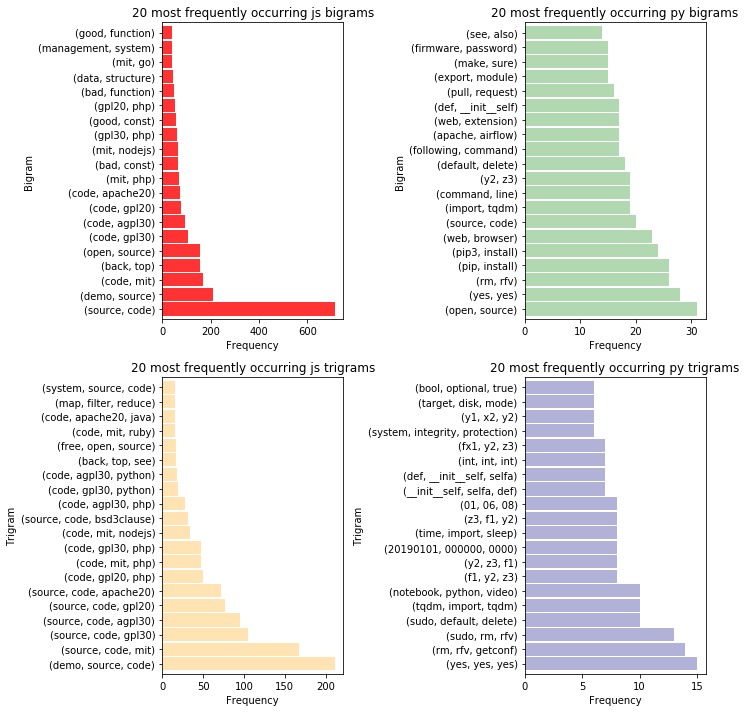

In [48]:
plt.subplot(221)
js_bigrams.head(20).plot.barh(color='red', width=.9, figsize=(10, 10), alpha=.8)
plt.title('20 most frequently occurring js bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

plt.subplot(222)
py_bigrams.head(20).plot.barh(color='green', width=.9, figsize=(10, 10), alpha=.3)
plt.title('20 most frequently occurring py bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

plt.subplot(223)
js_trigrams.head(20).plot.barh(color='orange', width=.9, figsize=(10, 10), alpha=.3)
plt.title('20 most frequently occurring js trigrams')
plt.ylabel('Trigram')
plt.xlabel('Frequency')

plt.subplot(224)
py_trigrams.head(20).plot.barh(color='navy', width=.9, figsize=(10, 10), alpha=.3)
plt.title('20 most frequently occurring py trigrams')
plt.ylabel('Trigram')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

---
## Model

In [82]:
# bag of words model
vectorizer = CountVectorizer(stop_words='english', 
                             min_df=30, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.clean)

# Get dictionary. 
vectorizer.get_feature_names()

# Transform each sentences in vector space.
bow = vectorizer.transform(train.clean)

# this is just to see the array of 0's and 1's
bow_array = bow.toarray()

X_bow = bow

In [78]:
# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', 
                        min_df=30, 
                        ngram_range=(1,2), 
                        binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.clean)

# Get vocabularies.
tfidf.vocabulary_

# Transform to document-term matrix
vector_spaces = tfidf.transform(train.clean)
vector_spaces.toarray()

X_tfidf = tfidf_sparse_matrix

In [66]:
# create our y dataset
y = train['language']

In [79]:
# BOW Log Reg Model
lm = LogisticRegression().fit(X_bow, y)
train['predict_bow'] = lm.predict(X_bow)

# TF-IDF Log Reg Model
lm_tfidf = LogisticRegression().fit(X_tfidf, y)
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf)

### Evaluate

In [80]:
print('Bag of Words Model \n', classification_report(train.language, train.predict_bow))
pd.crosstab(train.language, train.predict_bow)

Bag of Words Model 
               precision    recall  f1-score   support

  JavaScript       1.00      1.00      1.00        42
      Python       1.00      1.00      1.00        24

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



predict_bow,JavaScript,Python
language,,
JavaScript,42,0
Python,0,24


In [81]:
print('TF-IDF Model \n', classification_report(train.language, train.pred_tfidf))
pd.crosstab(train.language, train.pred_tfidf)

TF-IDF Model 
               precision    recall  f1-score   support

  JavaScript       0.71      1.00      0.83        42
      Python       1.00      0.29      0.45        24

    accuracy                           0.74        66
   macro avg       0.86      0.65      0.64        66
weighted avg       0.82      0.74      0.69        66



pred_tfidf,JavaScript,Python
language,,
JavaScript,42,0
Python,17,7


In [ ]:
pd.DataFrame()

---
## Conclusion